In [1]:
import tensorflow as tf
import keras
from keras import models, layers
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np

Preprocess the training data

In [12]:
normal_dir = '/Users/yash/Desktop/iocpl/FrameExtractor_NormalImages'
anomaly_dir = '/Users/yash/Desktop/iocpl/FrameExtractor_AnamolyImages'
def createImgPaths(img_dir):
    img_paths = []
    for root,dir,files in os.walk(img_dir):
        for file in files:
            img_paths.append(os.path.join(root,file))

    return img_paths

In [13]:
train_img_paths = createImgPaths(normal_dir)
test_img_paths = createImgPaths(anomaly_dir)

In [14]:
def createSet(img_paths):
    data=[]
    for path in img_paths:
        img = cv.imread(path)
        # resize the image the 224,224,3
        resized=cv.resize(img,(224,224),interpolation=cv.INTER_CUBIC)
        resized=resized.astype(float)/255.0
        data.append(resized)

    return data

In [15]:
train = createSet(train_img_paths)
test = createSet(test_img_paths)

In [16]:
def display(imgarr):
    plt.figure(figsize=(5,4))
    plt.imshow(imgarr)

(224, 224, 3)

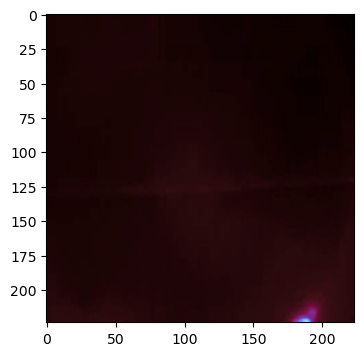

In [17]:
display(train[0])
train[0].shape

(224, 224, 3)

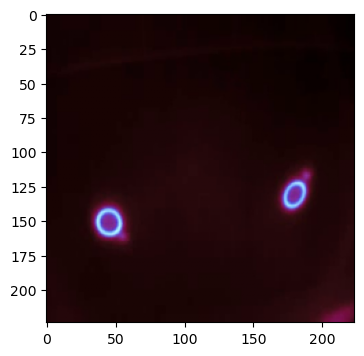

In [18]:
display(test[0])
train[0].shape

VGG16 autoencoder for anomaly detection

1. Convolution layers numbers = [2,2,3,3,3]
2. filters list = [64,128,256,512,512]
3. decoder filter list = [3, 3, 2, 1]

In [8]:
class ConvUnit(keras.layers.Layer):
    def __init__(self, Filter, units, stride=1, activation='relu'):
        super().__init__()
        self.layers = [ 
            layers.Conv2D(filters=Filter, strides=stride, activation=activation, kernel_size=3, padding='same', use_bias=False) for _ in range(units)
        ]
        self.layers.append(layers.MaxPool2D(pool_size=(2, 2), strides=2))
    
    def call(self, inputs):
        z = inputs
        for layer in self.layers:
            z = layer(z)
        return z

class TConvUnit(keras.layers.Layer):
    def __init__(self, Filter, units, stride=1, activation='relu'):
        super().__init__()
        self.layers=[
            layers.Conv2DTranspose(filters=Filter, strides=stride, activation=activation, kernel_size=3, padding='same', use_bias=False) for _ in range(units)
        ]
        self.layers.append(layers.UpSampling2D(size=(2, 2)))

    def call(self, inputs):
        z = inputs
        for layer in self.layers:
            z = layer(z)
        return z

# Define the encoder model
encoder = models.Sequential()
encoder.add(keras.Input(shape=(224, 224, 3), name="Input Layer"))
prev_filter = 64
for unit in [2, 2, 3, 3, 3]:
    f = prev_filter if prev_filter != 512 else 512
    encoder.add(ConvUnit(Filter=f, units=unit))
    prev_filter = min(prev_filter * 2, 512)
encoder.summary()

# Define the decoder model
decoder = models.Sequential()
decoder.add(keras.Input(shape=(7, 7, 512), name="Input layer decoder"))
prev_filter = 512
for unit in [3, 3, 2, 1]:
    f = prev_filter
    decoder.add(TConvUnit(Filter=int(f), units=unit))
    prev_filter = prev_filter // 2
decoder.add(layers.UpSampling2D(size=(2, 2)))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, activation='sigmoid', padding='same'))
decoder.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_unit (ConvUnit)            │ (None, 112, 112, 64)   │        38,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_unit_1 (ConvUnit)          │ (None, 56, 56, 128)    │       221,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_unit_2 (ConvUnit)          │ (None, 28, 28, 256)    │     1,474,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_unit_3 (ConvUnit)          │ (None, 14, 14, 512)    │     5,898,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_unit_4 (ConvUnit)          │ (None, 7, 7, 512)      │     7,077,888 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,710,464 (56.12 MB)

 Trainable params: 14,710,464 (56.12 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ t_conv_unit (TConvUnit)         │ (None, 14, 14, 512)    │     7,077,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_conv_unit_1 (TConvUnit)       │ (None, 28, 28, 256)    │     2,359,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_conv_unit_2 (TConvUnit)       │ (None, 56, 56, 128)    │       442,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ t_conv_unit_3 (TConvUnit)       │ (None, 112, 112, 64)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,955,011 (37.98 MB)

 Trainable params: 9,955,011 (37.98 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define the autoencoder
autoencoder = models.Sequential([encoder,decoder])
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │    14,710,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │     9,955,011 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,665,475 (94.09 MB)

 Trainable params: 24,665,475 (94.09 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
train_array = np.array(train)
train_array.shape

(498, 224, 224, 3)

In [29]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=5)
history = autoencoder.fit(
    x=train_array,
    y=train_array,
    epochs=100,
    batch_size=32,
    callbacks=callback
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 665s 42s/step - loss: 0.0518 - mse: 0.0518
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 398s 25s/step - loss: 0.0541 - mse: 0.0541
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 550s 35s/step - loss: 0.0518 - mse: 0.0518
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 409s 26s/step - loss: 0.0546 - mse: 0.0546
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1497s 98s/step - loss: 0.0529 - mse: 0.0529
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1388s 91s/step - loss: 0.0546 - mse: 0.0546
Epoch 7/100
13/16 ━━━━━━━━━━━━━━━━━━━━ 2:43:34 3271s/step - loss: 0.0588 - mse: 0.0588

In [19]:
#testing data
test_array = np.array(test)
test_array.shape

(236, 224, 224, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


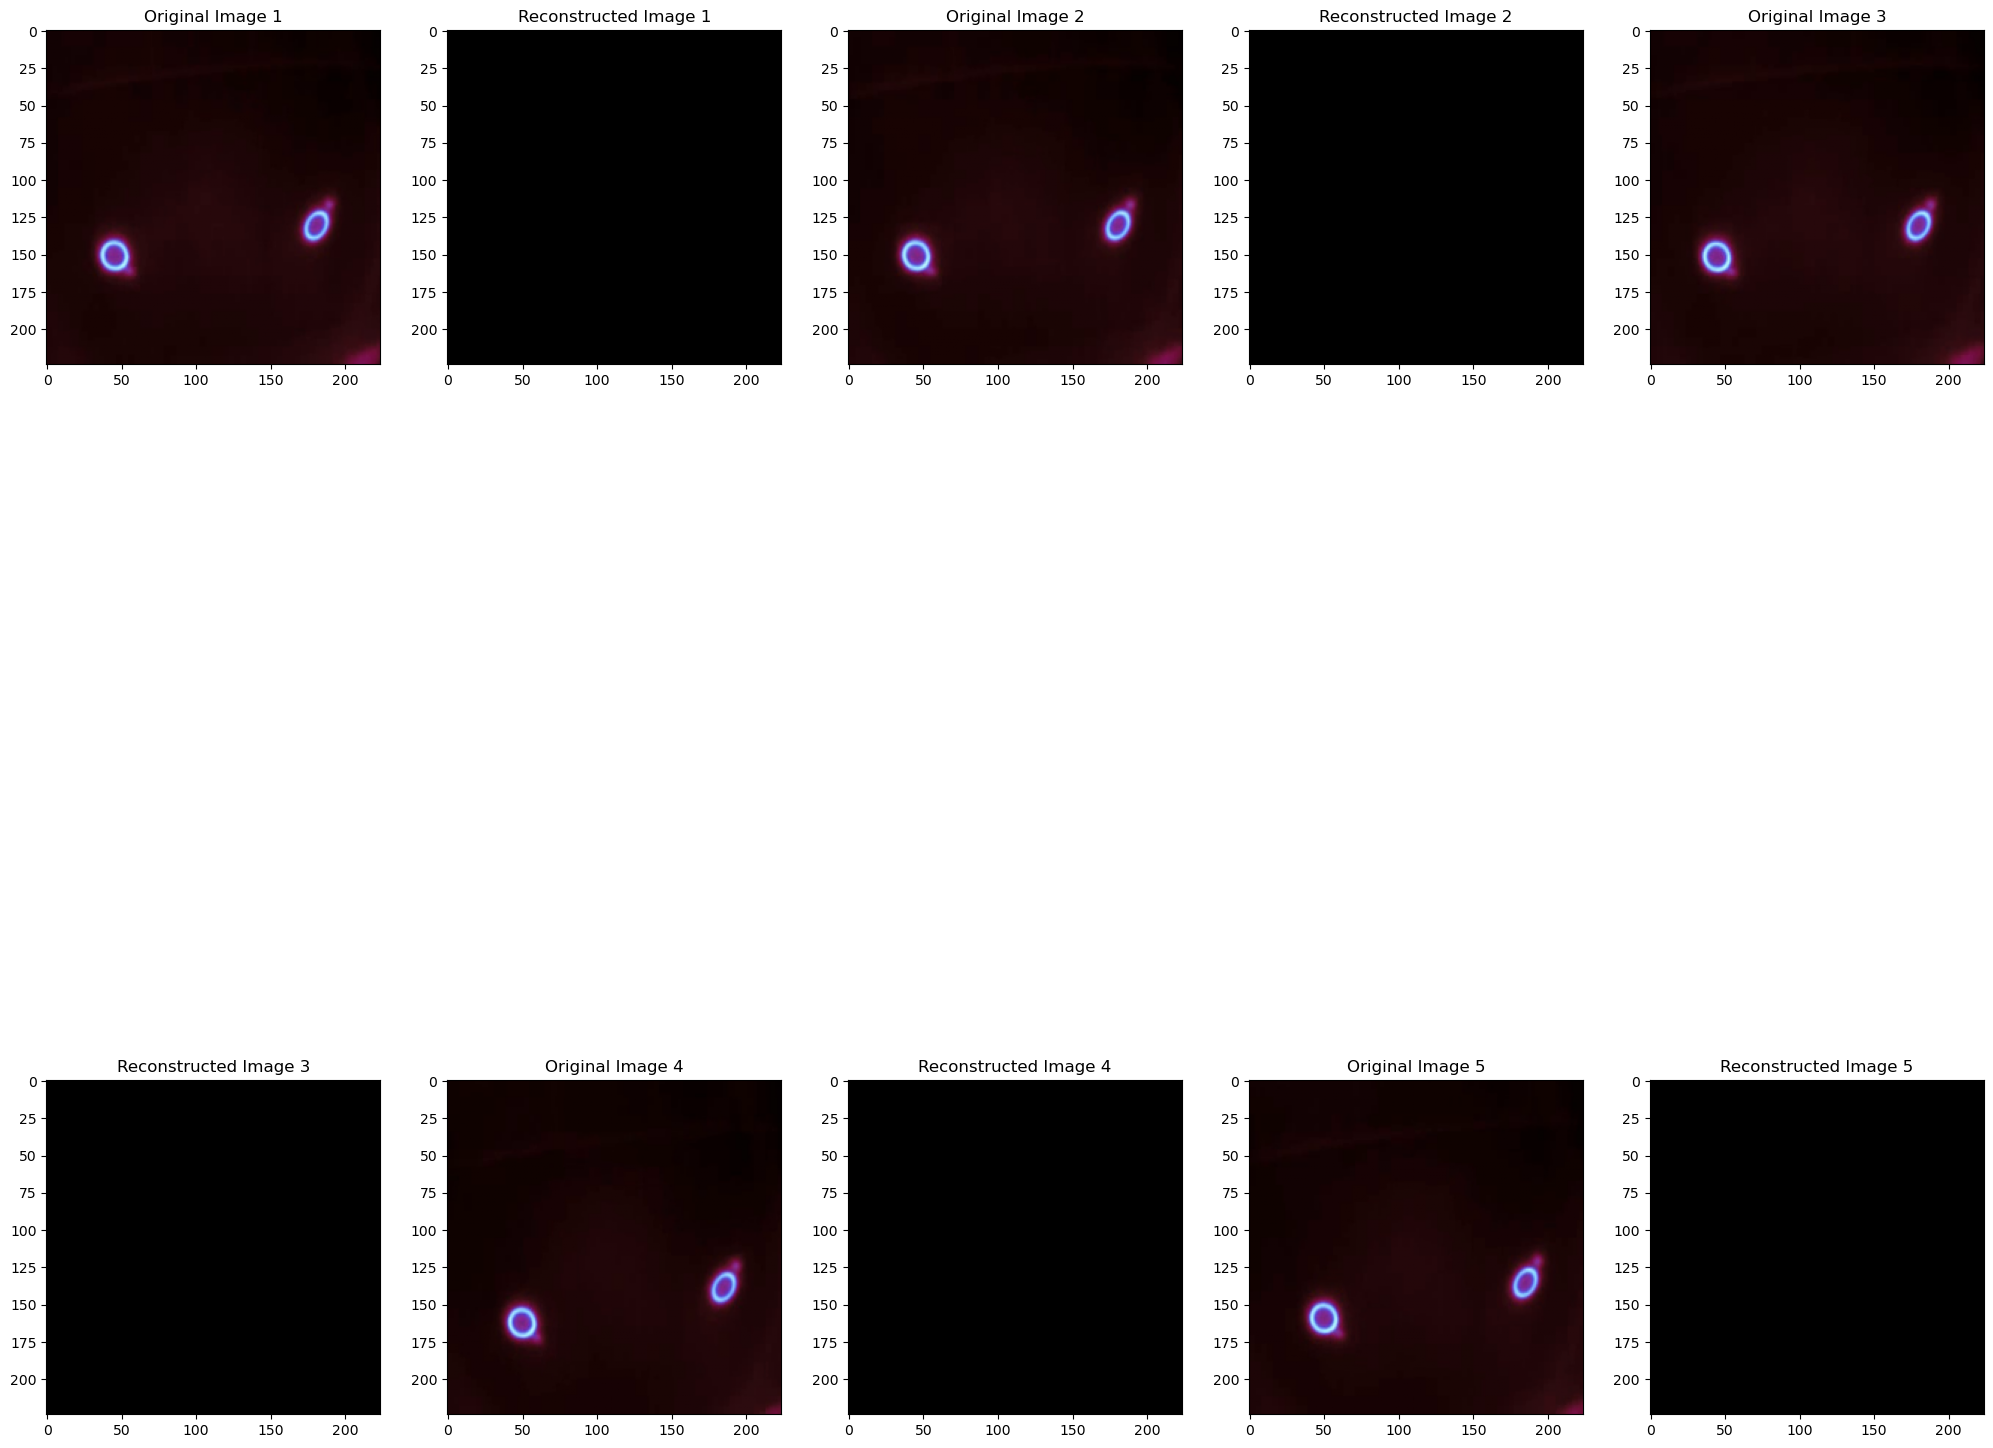

In [28]:
#predict the reconstructed images
results = autoencoder.predict(test_array[:5])
# Assuming you want to show 5 images in a 1x5 grid
rows, cols = 2, 5
plt.figure(figsize=(25,25))
for i in range(cols):
    # Assuming train_array contains the original images
    plt.subplot(rows, cols, i*2+1)
    plt.imshow(test_array[i])
    plt.title(f"Original Image {i+1}")
    plt.subplot(rows, cols, i*2+2)
    plt.imshow(results[i])
    plt.title(f"Reconstructed Image {i+1}")

